In [1]:
from torchvision import transforms
from torch.utils.data import Dataset

from PIL import Image
import torch.nn as nn
import umap
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torch
from torchvision.transforms import Resize
from torch.utils.data import ConcatDataset
import seaborn as sns
from torch.utils.data import Subset
from tqdm import tqdm

/home/mo/anaconda3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mo/anaconda3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mo/anaconda3/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

In [2]:
# 1. Data Selection


def crop_image(image_path, x, y, window_size=50):
    with Image.open(image_path) as img:
        left = x - window_size // 2
        upper = y - window_size // 2
        right = left + window_size
        lower = upper + window_size
        cropped_img = img.crop((left, upper, right, lower))
    return cropped_img


def load_checkpoint(model, optimizer, file_path="last.ckpt"):
    if os.path.isfile(file_path):
        checkpoint = torch.load(file_path)
        epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss = checkpoint['loss']

        print(f"Loaded checkpoint '{file_path}' (epoch {epoch})")
        return epoch, model, optimizer, loss
    else:
        print(f"No checkpoint found at '{file_path}'")
        return None, model, optimizer, None


def visualize_samples(model, samples):
    """
    Visualize original and autoencoded images.
    """
    model.eval()  # Set the model to evaluation mode
    fig, axs = plt.subplots(len(samples), 2, figsize=(10, 5 * len(samples)))
    
    for i, input_img in enumerate(samples):
        input_img = input_img.unsqueeze(0)
        with torch.no_grad():
            #print('input_shape',input_img.shape)
            output_img = model(input_img)
        
        axs[i, 0].imshow(input_img.squeeze().cpu().numpy(), cmap='gray')
        axs[i, 0].set_title('Original Image')
        
        axs[i, 1].imshow(output_img.squeeze().cpu().numpy(), cmap='gray')
        axs[i, 1].set_title('Autoencoded Image')
        
        for ax in axs[i]:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # assuming grayscale images
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 250)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(250, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.AdaptiveAvgPool2d((50, 50)) # Add this line to force the output size to 1x50x50# replacing the sigmoid with ReLU for an autoencoder
        )

    def forward(self, x):
        #print('inshape',x.shape)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_bottleneck(self, x):
        return self.encoder(x)

    
def get_umap_embeddings(data):
    reducer = umap.UMAP()
    embeddings = reducer.fit_transform(data)
    return embeddings

def plot_data(real_embeddings1, real_embeddings2, generated_embeddings):
    plt.figure(figsize=(10, 7))  # Bigger figure size
    plt.scatter(generated_embeddings[:, 0], generated_embeddings[:, 1], c='#2ca02c', s=30, label='Generated Cells', marker='s')  # green
    plt.scatter(real_embeddings1[:, 0], real_embeddings1[:, 1], c='#1f77b4', s=30, alpha=0.6,label='Training Cells', marker='o')  # blue
    plt.scatter(real_embeddings2[:, 0], real_embeddings2[:, 1], c='#ff7f0e', s=30, alpha=0.6,label='Test Cells', marker='^')  # orange
    plt.legend(fontsize=12)
    plt.xlabel('UMAP 1st component', fontsize=14)
    plt.ylabel('UMAP 2nd component', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
def plot_data_seaborn(real_embeddings1, real_embeddings2, generated_embeddings, save_path):
    # Convert embeddings to DataFrame for Seaborn plotting
    df1 = pd.DataFrame(real_embeddings1, columns=['UMAP 1st component', 'UMAP 2nd component'])
    df1['Type'] = 'Training Cells'
    
    df2 = pd.DataFrame(real_embeddings2, columns=['UMAP 1st component', 'UMAP 2nd component'])
    df2['Type'] = 'Test Cells'
    
    df_gen = pd.DataFrame(generated_embeddings, columns=['UMAP 1st component', 'UMAP 2nd component'])
    df_gen['Type'] = 'Generated Cells'
    
    # Plotting without real_cells_2
    combined_df_without_rc2 = pd.concat([df_gen, df1])
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=combined_df_without_rc2, x='UMAP 1st component', y='UMAP 2nd component', hue='Type',
                    palette={"Training Cells": "#3498db", "Generated Cells": "#2ecc71"},
                    style='Type', markers={"Training Cells": "o", "Generated Cells": "s"},
                    s=80, alpha=0.8, edgecolor='none')
    
    plt.legend(fontsize=12, loc='upper right')
    plt.xlabel('UMAP 1st component', fontsize=14)
    plt.ylabel('UMAP 2nd component', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig(f"{save_path}/plot_without_real_cells_2.png")
    plt.show()
    
    # Plotting with all datasets
    combined_df_with_all = pd.concat([df_gen, df1, df2])
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=combined_df_with_all, x='UMAP 1st component', y='UMAP 2nd component', hue='Type',
                    palette={"Training Cells": "#3498db", "Test Cells": "#e74c3c", "Generated Cells": "#2ecc71"},
                    style='Type', markers={"Training Cells": "o", "Test Cells": "^", "Generated Cells": "s"},
                    s=80, alpha=0.8, edgecolor='none')
    
    plt.legend(fontsize=12, loc='upper right')
    plt.xlabel('UMAP 1st component', fontsize=14)
    plt.ylabel('UMAP 2nd component', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig(f"{save_path}/plot_with_all_datasets.png")
    plt.show()

    
class CellDataset(Dataset):
    def __init__(self, root_dir, window, transform=None):
        # Load all TXT files in root_dir into a list of dataframes
        all_dfs = []
        for folder in os.listdir(root_dir):
            if folder.endswith("_GT"):
                file_path = os.path.join(root_dir, folder, 'TRA', 'pos_GT.txt')
                if os.path.exists(file_path):
                    run = int(folder.split('_')[0])
                    df = pd.read_csv(file_path, delimiter='\t', skiprows=1, 
                                     names=['x', 'y', 'r', 'id', 'split_id', 's_prob', 't'])
                    df['run'] = run  # Add a run column
                    all_dfs.append(df)

        concatenated_data = pd.concat(all_dfs, ignore_index=True)
        # Filter out rows where 'id' is a negative number
        self.data = concatenated_data[concatenated_data['id'] >= 0]
        self.root_dir = root_dir
        self.transform = transform
        self.window = window

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        cell_frame = self._load_frame(self.data.iloc[idx])
        return cell_frame

    def _load_frame(self, row):
        pos_x, pos_y, run, t = row['x'], row['y'], row['run'], row['t']
        im_tens = fingerprint_cnn(pos_x, pos_y, self.window, t, run, path0=self.root_dir)
        return im_tens
    
    
def fingerprint_cnn(pos_x, pos_y, window, t, run, void_node=False, a_x=113.89266922, b_x=19.51478307, a_y=-114.14194117, b_y=131.3404747, path0='.'):
    v_flag=False
    #if pos_x==2:
    #    path=path0+'void.png'
    #    v_flag=True
    #else:
    path=path0+str(int(run))+'/'+str(int(t))+'.png'

    x_l, x_r, y_l, y_u = calibrate_pix_pos(pos_x, pos_y, a_x, b_x, a_y, b_y, window)
    im = Image.open(path).convert('L')
    
    if v_flag:
        im_crop = im
    else:
        im_crop = im.crop((x_l, y_l, x_r, y_u))

    im_crop = im_crop.resize((50,50), Image.ANTIALIAS)
    
    convert_tensor = transforms.ToTensor()
    im_tens = convert_tensor(im_crop)
    
    return im_tens


def calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window):
    #pix_x0=int(fit_func(pos_x,a_x,b_x))
    #pix_y0 = pos_x* 512
    #pix_x0 = (1-pos_y) * 512
    pix_x0 = pos_x* 512
    pix_y0 = (1-pos_y) * 512
    #pix_y0=int(fit_func(pos_y,a_y,b_y))
    #print(pix_x0,pix_y0,int(pix_x0-window))
    return int(pix_x0-window),int(pix_x0+window),int(pix_y0-window),int(pix_y0+window)

class RealCellDataset(Dataset):
    def __init__(self, root_dir, window, transform=None):
        # Load all TXT files in root_dir into a list of dataframes
        all_dfs = []
        for folder in os.listdir(root_dir):
            if folder.endswith("_GT"):
                file_path = os.path.join(root_dir, folder, 'TRA', 'pos_GT.txt')
                if os.path.exists(file_path):
                    run = int(folder.split('_')[0])
                    df = pd.read_csv(file_path, delimiter='\t', skiprows=1, 
                                     names=['x', 'y', 'r', 'id', 'split_id', 's_prob', 't'])
                    df['run'] = run  # Add a run column
                    all_dfs.append(df)

        self.data = pd.concat(all_dfs, ignore_index=True)
        self.root_dir = root_dir
        self.transform = transform
        self.window = window
        self.resize = transforms.Resize((50,50))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        cell_frame = self._load_frame(self.data.iloc[idx])
        return cell_frame

    def _load_frame(self, row):
        pos_x, pos_y, run, t = row['x'], row['y'], row['run'], int(row['t'])
        # Updated pixel calibration
        pix_x0 = pos_x * 512
        pix_y0 = pos_y * 512
        im_tens = self._load_and_crop_tif(pix_x0, pix_y0, self.window, t, run)
        im_tens = self.resize(im_tens)
        return im_tens

    def _load_and_crop_tif(self, x, y, window, t, run):
        # Construct path to the TIF image, considering the naming conventions you provided
        tif_path = os.path.join(self.root_dir, f"{int(run):02}", f"t{t:03}.tif")
        with Image.open(tif_path) as img:
            # Resize image to 512x512
            img = Resize((512, 512))(img)
            # Crop around the specified coordinates
            left = int(x - window)
            upper = int(y - window)
            right = int(x + window)
            lower = int(y + window)
            img_cropped = img.crop((left, upper, right, lower))
        if self.transform:
            img_cropped = self.transform(img_cropped)
        return img_cropped
    
    
def after_training_procedure(model, real_dataloader1, real_dataloader2, generated_dataloader):
    with torch.no_grad():
        # Get embeddings for first real data
        real_data1 = [data for data in real_dataloader1]
        real_data1 = torch.cat(real_data1, dim=0)
        real_embeddings1 = model.get_bottleneck(real_data1).cpu().numpy()
        print('#real1', len(real_embeddings1))
        
        # Get embeddings for second real data
        real_data2 = [data for data in real_dataloader2]
        real_data2 = torch.cat(real_data2, dim=0)
        real_embeddings2 = model.get_bottleneck(real_data2).cpu().numpy()
        print('#real2', len(real_embeddings2))

        # Subset the generated data to take only 10%
        percentage_to_take = 0.15
        all_generated_data = []
        num_samples = len(generated_dataloader.dataset)
        num_samples_to_take = int(num_samples * percentage_to_take)
        samples_taken = 0
        for data in generated_dataloader:
            all_generated_data.append(data)
            samples_taken += len(data)
            if samples_taken >= num_samples_to_take:
                break
        
        all_generated_data = torch.cat(all_generated_data, dim=0)
        generated_embeddings = model.get_bottleneck(all_generated_data).cpu().numpy()
        print('#gen', len(generated_embeddings))

    # Combine all embeddings
    combined_embeddings = np.vstack([real_embeddings1, real_embeddings2, generated_embeddings])
    print('starting umap with', len(combined_embeddings))

    # Get UMAP embeddings for combined data
    combined_umap = get_umap_embeddings(combined_embeddings)

    # Split the UMAP embeddings
    num_real_samples1 = real_embeddings1.shape[0]
    num_real_samples2 = real_embeddings2.shape[0]
    real_umap1 = combined_umap[:num_real_samples1]
    real_umap2 = combined_umap[num_real_samples1:num_real_samples1 + num_real_samples2]
    generated_umap = combined_umap[num_real_samples1 + num_real_samples2:]

    plot_data_seaborn(real_umap1, real_umap2, generated_umap,'/home/mo/Desktop/IWR/Cell_GT_Proj/final_plots')
    
def save_checkpoint(epoch, model, optimizer, loss, file_path="last.ckpt"):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, file_path)
    
    
def load_checkpoint(model, optimizer, file_path="last.ckpt"):
    if os.path.isfile(file_path):
        checkpoint = torch.load(file_path)
        epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss = checkpoint['loss']

        print(f"Loaded checkpoint '{file_path}' (epoch {epoch})")
        return epoch, model, optimizer, loss
    else:
        print(f"No checkpoint found at '{file_path}'")
        return None, model, optimizer, None
def calculate_euclidean_distance(embedding1, embedding2):
    """Calculate the Euclidean distance between two embeddings."""
    return torch.norm(embedding1 - embedding2, p=2).item()
class CellTrackingDataset(Dataset):
    def __init__(self, root_dir, window,transform=None):
        # Load all TXT files in root_dir into a list of dataframes
        all_dfs = []
        for folder in os.listdir(root_dir):
            print('folder',folder)
            # Check if the folder's name ends with '_GT'
            if folder.endswith("_GT"):#folder=='1_GT': #!!!!!!!!
                file_path = os.path.join(root_dir, folder, 'TRA','pos_GT.txt')
                print('file_path',file_path)
                # Check if 'pos_GT.txt' actually exists in the folder
                if os.path.exists(file_path):
                    print('file', file_path)
                    run = int(folder.split('_')[0])  # extract run number from folder name
                    print('run', run)
                    df = pd.read_csv(file_path, delimiter='\t', skiprows=1, 
                                     names=['x', 'y', 'r', 'id', 'split_id', 's_prob', 't'])
                    df['run'] = run  # Add a run column
                    all_dfs.append(df)

        self.data = pd.concat(all_dfs, ignore_index=True)
        self.root_dir = root_dir
        self.transform = transform
        self.window=window

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # TODO: Implement logic to decide positive or negative pair
        # For example, 50% of the time it returns positive pairs, and 50% negative pairs
        positive_sample = np.random.choice([True, True])

        if positive_sample:
            # Load two consecutive frames of the same cell
            #print("IDX:", idx, "DATA LENGTH:", len(self.data), self.data.iloc[idx])
            frame_t, frame_t_plus_1 = self._load_consecutive_frames(self.data.iloc[idx])
            label = torch.tensor([1.0])
        else:
            # Load frames of two different cells (from consecutive frames)
            #print("IDX:", idx, "DATA LENGTH:", len(self.data), self.data.iloc[idx])
            frame_t, frame_t_plus_1 = self._load_different_cells_frames(self.data.iloc[idx])
            label = torch.tensor([0.0])

        return (frame_t, frame_t_plus_1), label

    def _load_consecutive_frames(self, row):
        # Find the next frame's cell that has either the same 'id' 
        # or has 'split_id' matching the current 'id'
        if row['id'] ==-1 or row['id']==-2:
            same_cell_or_daughter = self.data[(self.data['run'] == row['run']) & 
                                          ((self.data['id'] == row['id']) | 
                                           (self.data['split_id'] == row['id'])|
                                           (self.data['id'] == row['split_id']))]
        else:
            same_cell_or_daughter = self.data[(self.data['t'] == row['t'] + 1) & 
                                              (self.data['run'] == row['run']) & 
                                              ((self.data['id'] == row['id']) | 
                                               (self.data['split_id'] == row['id']))]

        if not same_cell_or_daughter.empty:
            next_frame_same_cell = same_cell_or_daughter.sample(n=1).iloc[0]
            frame_t_plus_1 = self._load_frame(next_frame_same_cell)
        else:
            # Handle the scenario when no such cell exists in the next frame
            frame_t_plus_1 = torch.zeros_like(self._load_frame(row))  # Placeholder, modify as needed

        frame_t = self._load_frame(row)

        return frame_t, frame_t_plus_1

    def _load_different_cells_frames(self, row):
        # Find another cell from the next frame but within the same run 
        # and is not a daughter cell (i.e., its 'split_id' doesn't match the current cell's 'id')
        
        if row['id'] ==-1:
            next_frame_data = self.data[(self.data['run'] == row['run']) & 
                                        (self.data['split_id'] != row['id'])]
        else:
             next_frame_data = self.data[(self.data['t'] == row['t'] + 1) & 
                                        (self.data['run'] == row['run']) & 
                                        (self.data['split_id'] != row['id'])]
            

        # Ensure that you're getting a different cell, but from the same run
        different_cell = next_frame_data[next_frame_data['id'] != row['id']]

        if not different_cell.empty:
            different_cell_row = different_cell.sample(n=1).iloc[0]
            frame_t_plus_1 = self._load_frame(different_cell_row)
        else:
            # Handle the scenario when no different cell exists in t+1 frame
            frame_t_plus_1 = torch.zeros_like(self._load_frame(row))  # Placeholder, modify as needed

        frame_t = self._load_frame(row)

        return frame_t, frame_t_plus_1
    def _load_frame(self, row):
        # Extract position and run from the row
        pos_x, pos_y, run, t = row['x'], row['y'], row['run'], row['t']
        # Using the fingerprint_cnn function to get the tensor
        im_tens = fingerprint_cnn(pos_x, pos_y, self.window, t, run,path0=self.root_dir)
        return im_tens
    
    
class RealCellTrackingDataset(Dataset):
    def __init__(self, root_dir, window, transform=None):
        # Load all TXT files in root_dir into a list of dataframes
        all_dfs = []
        for folder in os.listdir(root_dir):
            if folder.endswith("_GT"):
                file_path = os.path.join(root_dir, folder, 'TRA', 'pos_GT.txt')
                if os.path.exists(file_path):
                    run = int(folder.split('_')[0])
                    df = pd.read_csv(file_path, delimiter='\t', skiprows=1, 
                                     names=['x', 'y', 'r', 'id', 'split_id', 's_prob', 't'])
                    df['run'] = run  # Add a run column
                    all_dfs.append(df)
        self.data = pd.concat(all_dfs, ignore_index=True)
        self.root_dir = root_dir
        self.transform = transform
        self.window = window
        self.resize = transforms.Resize((50,50))
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        positive_sample = np.random.choice([True, False])
        if positive_sample:
            frame_t, frame_t_plus_1 = self._load_consecutive_frames(self.data.iloc[idx])
            label = torch.tensor([1.0])
        else:
            frame_t, frame_t_plus_1 = self._load_different_cells_frames(self.data.iloc[idx])
            label = torch.tensor([0.0])
        return (frame_t, frame_t_plus_1), label

    def _load_consecutive_frames(self, row):
        # Find the next frame's cell that has either the same 'id' 
        # or has 'split_id' matching the current 'id'
        if row['id'] ==-1 or row['id']==-2:
            same_cell_or_daughter = self.data[(self.data['run'] == row['run']) & 
                                          ((self.data['id'] == row['id']) | 
                                           (self.data['split_id'] == row['id'])|
                                           (self.data['id'] == row['split_id']))]
        else:
            same_cell_or_daughter = self.data[(self.data['t'] == row['t'] + 1) & 
                                              (self.data['run'] == row['run']) & 
                                              ((self.data['id'] == row['id']) | 
                                               (self.data['split_id'] == row['id']))]

        if not same_cell_or_daughter.empty:
            next_frame_same_cell = same_cell_or_daughter.sample(n=1).iloc[0]
            frame_t_plus_1 = self._load_frame(next_frame_same_cell)
        else:
            # Handle the scenario when no such cell exists in the next frame
            frame_t_plus_1 = torch.zeros_like(self._load_frame(row))  # Placeholder, modify as needed

        frame_t = self._load_frame(row)

        return frame_t, frame_t_plus_1

    def _load_different_cells_frames(self, row):
        # Find another cell from the next frame but within the same run 
        # and is not a daughter cell (i.e., its 'split_id' doesn't match the current cell's 'id')
        
        if row['id'] ==-1:
            next_frame_data = self.data[(self.data['run'] == row['run']) & 
                                        (self.data['split_id'] != row['id'])]
        else:
             next_frame_data = self.data[(self.data['t'] == row['t'] + 1) & 
                                        (self.data['run'] == row['run']) & 
                                        (self.data['split_id'] != row['id'])]
            

        # Ensure that you're getting a different cell, but from the same run
        different_cell = next_frame_data[next_frame_data['id'] != row['id']]

        if not different_cell.empty:
            different_cell_row = different_cell.sample(n=1).iloc[0]
            frame_t_plus_1 = self._load_frame(different_cell_row)
        else:
            # Handle the scenario when no different cell exists in t+1 frame
            frame_t_plus_1 = torch.zeros_like(self._load_frame(row))  # Placeholder, modify as needed

        frame_t = self._load_frame(row)

        return frame_t, frame_t_plus_1
    def _load_frame(self, row):
        pos_x, pos_y, run, t = row['x'] * 512, row['y'] * 512, row['run'], int(row['t'])
        im_tens = self._load_and_crop_tif(pos_x, pos_y, self.window, t, run)
        im_tens = self.resize(im_tens)
        return self.to_tensor(im_tens)

    def _load_and_crop_tif(self, x, y, window, t, run):
        tif_path = os.path.join(self.root_dir, f"{int(run):02}", f"t{t:03}.tif")
        with Image.open(tif_path) as img:
            img = Resize((512, 512))(img)
            left = int(x - window)
            upper = int(y - window)
            right = int(x + window)
            lower = int(y + window)
            img_cropped = img.crop((left, upper, right, lower))
        if self.transform:
            img_cropped = self.transform(img_cropped)
        return img_cropped
    
def visualize_input_frames(frame_t, frame_t_plus_1):
    """
    Visualize input images for two consecutive frames side by side.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
    
    # Display original images for frame_t and frame_t_plus_1
    axs[0].imshow(frame_t.squeeze().cpu().numpy(), cmap='gray')
    axs[0].set_title('Frame t')
    
    axs[1].imshow(frame_t_plus_1.squeeze().cpu().numpy(), cmap='gray')
    axs[1].set_title('Frame t+1')
    
    for ax in axs:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def extract_distances_and_labels(data_loader, num_samples_to_take):
    distances = []
    labels = []
    samples_taken = 0
    for ((frame_t, frame_t_plus_1), label) in tqdm(data_loader, total=num_samples_to_take):
        if samples_taken >= num_samples_to_take:
            break
        if not torch.equal(frame_t_plus_1, torch.zeros_like(frame_t)):
            embedding1 = model.get_bottleneck(frame_t)
            embedding2 = model.get_bottleneck(frame_t_plus_1)
            distance = calculate_euclidean_distance(embedding1.squeeze(0), embedding2.squeeze(0))
            distances.append(distance)
            labels.append(label)
            samples_taken += 1
    return distances, labels


def plot_distance_histograms(distances_gen, distances_real_label_1, distances_real_label_0, save_path):
    # Create a DataFrame for seaborn plotting
    df_gen = pd.DataFrame({"Distance": distances_gen, "Type": "Generated Cells"})
    df_real_1 = pd.DataFrame({"Distance": distances_real_label_1, "Type": "Real Cells (label 1.0)"})
    df_real_0 = pd.DataFrame({"Distance": distances_real_label_0, "Type": "Real Cells (label 0.0)"})
    
    # Combine dataframes
    combined_df = pd.concat([df_gen, df_real_1, df_real_0])
    
    # Create the plot
    plt.figure(figsize=(10, 7))
    sns.histplot(data=combined_df, x="Distance", hue="Type", kde=True, bins=30,
                 palette={"Real Cells (label 1.0)": "#3498db", "Real Cells (label 0.0)": "#e74c3c", "Generated Cells": "#2ecc71"})
    
    # Set plot aesthetic properties
    plt.title('Distribution of Euclidean Distances', fontsize=16)
    plt.xlabel('Euclidean Distance', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12, loc='upper right')
    sns.despine(left=True, bottom=True)  # Removes the top and right spines for a cleaner look
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    plt.savefig(f"{save_path}/distance_distributions.png")
    plt.show()


In [3]:
print(stop)

NameError: name 'stop' is not defined

In [ ]:

# 1. Define Loss Function and Optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 2. Dataloader setup
#root_dir = '/media/mo/Label/HUH_art/'  # Replace with the path to your data
root_dir_real='/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/'
root_dir_gen='/media/mo/Label/HUH_art/'
root_dir_real_test='/media/mo/Label/HUH_01_t/'
real_dataset = RealCellDataset(root_dir_real,25,transform= transforms.ToTensor())
generated_dataset = CellDataset(root_dir_gen,25)
combined_dataset = ConcatDataset([real_dataset,generated_dataset])
combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)


sample_dataloader = DataLoader(real_dataset, batch_size=32, shuffle=True, num_workers=0)
data_iter = iter(sample_dataloader)
sample_inputs = [next(data_iter)[0] for _ in range(5)]  # Assumes batch_size of 1


visualize_samples(model, sample_inputs)
print(stop)
# 3. Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(combined_dataloader, 0):
        inputs = data.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Note: targets for autoencoders are the inputs themselves

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print average epoch loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(combined_dataloader):.4f}")
    visualize_samples(model, sample_inputs)
    save_checkpoint(epoch, model, optimizer, loss.item(), os.path.join('/media/mo/Label', "last_umap.ckpt"))
print('Finished Training')

In [ ]:
model = ConvAutoencoder()
optimizer = torch.optim.Adam(model.parameters())



real_test_dataset = RealCellDataset(root_dir_real_test,25,transform= transforms.ToTensor())

epoch, model, optimizer, loss = load_checkpoint(model, optimizer, os.path.join('/media/mo/Label', "last_umap.ckpt"))
model.eval()
real_dataloader=DataLoader(real_dataset, batch_size=32, shuffle=True, num_workers=0)
generated_dataloader=DataLoader(generated_dataset, batch_size=32, shuffle=True, num_workers=0)
real_test_dataloader=DataLoader(real_test_dataset, batch_size=32, shuffle=True, num_workers=0)
# Now, you can use the loaded model in your after training procedure:
after_training_procedure(model, real_dataloader, real_test_dataloader, generated_dataloader)


In [ ]:
generated_cell_tracking_dataset = CellTrackingDataset(root_dir=root_dir_gen, window=25)


real_cell_tracking_dataset1 = RealCellTrackingDataset(root_dir=root_dir_real, window=25)
real_cell_tracking_dataset2 = RealCellTrackingDataset(root_dir=root_dir_real_test, window=25)

real_cell_tracking_dataset = ConcatDataset([real_cell_tracking_dataset1, real_cell_tracking_dataset2])

data_loader_gen = DataLoader(generated_cell_tracking_dataset, batch_size=1, shuffle=False)
data_loader_real = DataLoader(real_cell_tracking_dataset, batch_size=1, shuffle=False)

model = ConvAutoencoder()
optimizer = torch.optim.Adam(model.parameters())

epoch, model, optimizer, loss = load_checkpoint(model, optimizer, os.path.join('/media/mo/Label', "last_umap.ckpt"))
model.eval()

percentage_to_take = 0.3
num_samples_gen = len(data_loader_gen.dataset)
num_samples_real = len(data_loader_real.dataset)
print('gen',num_samples_gen)
print('real',num_samples_real)
distances_gen = extract_distances_and_labels(data_loader_gen, int(num_samples_real/2))[0]  # We only need distances for generated
distances_real, labels_real = extract_distances_and_labels(data_loader_real, int(num_samples_real))

distances_real_label_1 = [dist for dist, label in zip(distances_real, labels_real) if label == 1.0]
distances_real_label_0 = [dist for dist, label in zip(distances_real, labels_real) if label == 0]

# Given plotting function
plot_distance_histograms(distances_gen, distances_real_label_1, distances_real_label_0, "/home/mo/Desktop/IWR/Cell_GT_Proj/final_plots")

In [35]:
arr=[0.958586,0.962259,0.958448]
print(np.mean(arr),np.std(arr))

0.9597643333333332 0.0017648951495453883


# HUH

In [36]:
gen_num=[30,42,66,90,150,330]
gen_per=[1,30/42,30/66,30/90,30/150,30/330]
gen_val=[0.95976433,0.9607665,0.963861,0.96640275,0.956749,0.95277]
gen_std=[0.00176,0.00317,0.00829,0.00254,0.00167,0.00167]



real_num=[30,60,90,150,330]
real_val=[0.9603535,0.9647,0.96685,0.968687,0.968916]
real_per=[1,1,1,1,1]
real_std=[0.0019,0.0019,0.0019,0.0019,0.0019]

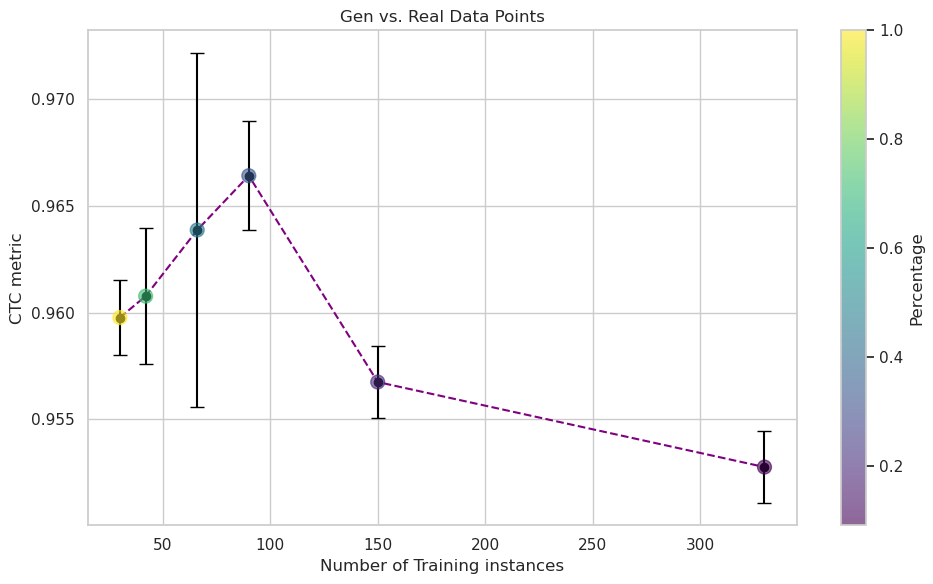

In [37]:
# Plot
plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid")

# Gen data points
sc1 = plt.scatter(gen_num, gen_val, c=gen_per, cmap='viridis', s=100, label='Gen', zorder=5,alpha=0.6)
plt.errorbar(gen_num, gen_val, yerr=gen_std, fmt='o', color='black', capsize=5)
plt.plot(gen_num, gen_val, color='purple', linestyle='--')

 #Real data points
#sc2 = plt.scatter(real_num, real_val, c='black', s=100, marker='s', label='Real', zorder=5,alpha=0.6)
#plt.errorbar(real_num, real_val, yerr=real_std, fmt='s', color='black', capsize=5)
#plt.plot(real_num, real_val, color='green', linestyle='--')

# Miscellaneous plot settings
plt.colorbar(sc1, label='Percentage')
plt.xlabel('Number of Training instances')
plt.ylabel('CTC metric')
plt.title('Gen vs. Real Data Points')
#plt.legend()
plt.tight_layout()
plt.show()

# MSC

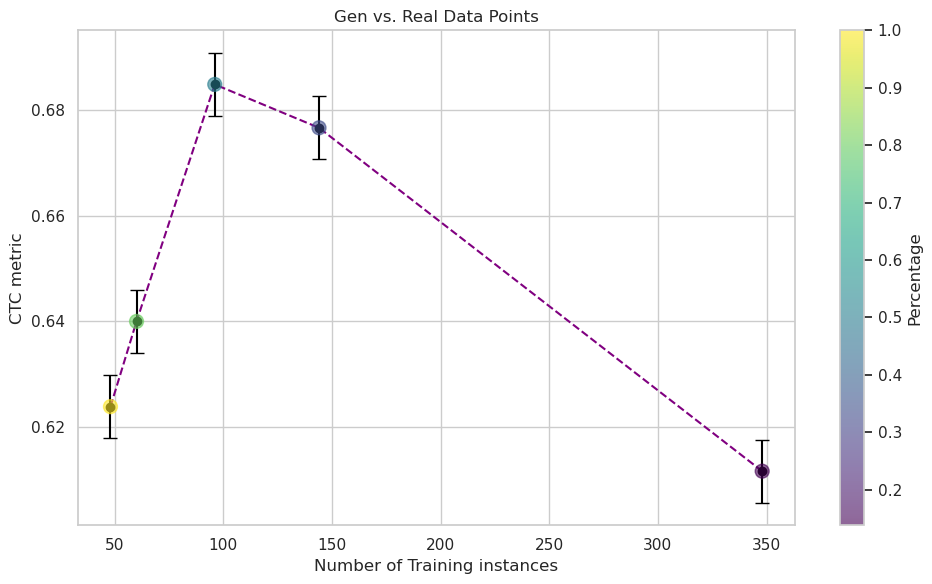

In [34]:
gen_num=[48,48+1*12,48+4*12,48+8*12,48+25*12]
gen_per=[1,48/(48+1*12),48/(48+4*12),48/(48+8*12),48/(48+25*12)]
gen_val=[0.62389,0.64,0.6848,0.6766,0.611695]
gen_std=[0.005969,0.005969,0.005969,0.005969,0.005969]


plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid")

# Gen data points
sc1 = plt.scatter(gen_num, gen_val, c=gen_per, cmap='viridis', s=100, label='Gen', zorder=5,alpha=0.6)
plt.errorbar(gen_num, gen_val, yerr=gen_std, fmt='o', color='black', capsize=5)
plt.plot(gen_num, gen_val, color='purple', linestyle='--')

 #Real data points
#sc2 = plt.scatter(real_num, real_val, c='black', s=100, marker='s', label='Real', zorder=5,alpha=0.6)
#plt.errorbar(real_num, real_val, yerr=real_std, fmt='s', color='black', capsize=5)
#plt.plot(real_num, real_val, color='green', linestyle='--')

# Miscellaneous plot settings
plt.colorbar(sc1, label='Percentage')
plt.xlabel('Number of Training instances')
plt.ylabel('CTC metric')
plt.title('Gen vs. Real Data Points')
#plt.legend()
plt.tight_layout()
plt.show()

# HELA

In [ ]:
# HELA
gen_num=[48,48+1*12,48+4*12,48+8*12,48+25*12]
gen_per=[1,48/(48+1*12),48/(48+4*12),48/(48+8*12),48/(48+25*12)]
gen_val=[0.62389,0.64,0.6848,0.6766,0.611695]
gen_std=[0.005969,0.005969,0.005969,0.005969,0.005969]